In [ ]:
#! pip install pipreqs

In [ ]:
#! pipreqs --encoding=utf-8 c:/Users/Diya/Documents/GItHub/DELTA_Element3

# 0. Import Libraries 

In [1]:
# # For preprocessing
import pandas as pd
import numpy as np
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# from collections import Counter
# from imblearn.over_sampling import SMOTE
import nltk
# from nltk.corpus import stopwords
# import re
# from bs4 import BeautifulSoup
# import emoji
# from urllib.parse import urlparse
# import seaborn as sns
# import matplotlib.pyplot as plt

from DataPreprocess import DataPreprocessor

from ClassificationScores import ClassificationEvaluator

# For VaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# For RNN model 
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# For DistilBERT
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# 1. Data Preprocessing

### 1.1. Importing the data and getting known to it.

In [2]:
# Importing the train and test datasets
train_df = pd.read_parquet('btc_tweets_train.parquet.gzip')
test_df = pd.read_parquet('btc_tweets_test.parquet.gzip')

In [3]:
train_df = train_df.reset_index()
test_df = test_df.reset_index()

In [ ]:
def df_info(df):
    return df.shape, df.isnull().sum().sum(), df.info(), df.head()

In [ ]:
# Running a few checks to understand the datasets
df_info(train_df)

In [ ]:
df_info(test_df)

In [4]:
# Dropping the unnecessary features (Hashtags in the tweets are seperately handled ahead)
train_df = train_df.drop(['tweet ID', 'user_displayname', 'hashtags'], axis=1)
test_df = test_df.drop(['tweet ID', 'user_displayname', 'hashtags'], axis=1)

In [5]:
# Converting the sentiment labels from bool to int
train_df['sentiment'] = train_df['sentiment'].astype(int)
test_df['sentiment'] = test_df['sentiment'].astype(int)

### 1.2. DataPreprocessor Class

In [6]:
# Initialize the class for train and test df
train_datapreprocessor = DataPreprocessor(df=train_df, content_column='content')
test_datapreprocessor = DataPreprocessor(df=test_df, content_column='content')

### A few trials

In [ ]:
def extract_special_characters(text):
    # Regular expression to match special characters
    return re.findall(r'[^a-zA-Z0-9\s]', text)

# Extract special characters from the selected column (e.g., 'content')
df = train_df.copy()
df['special_chars'] = df['content'].apply(extract_special_characters)

# Flatten the list of special characters and count their frequency
special_chars_list = df['special_chars'].sum()
special_chars_count = Counter(special_chars_list)

# Get the most common special characters
most_common_special_chars = special_chars_count.most_common()

# Display the results
for char, count in most_common_special_chars:
    print(f"'{char}': {count}")

In [ ]:
🤔😂😳😂

In [ ]:
def extract_emojis(text):
    return ''.join(char for char in text if char in emoji.EMOJI_DATA)

# Extract emojis from the selected column (e.g., 'content')
#column_to_use = 'cleaned_content' if 'cleaned_content' in df.columns else 'content'
df = train_df.copy()
df['emojis'] = df['content'].apply(extract_emojis)

# Flatten the list of emojis and count the frequency of each emoji
emoji_list = df['emojis'].sum()
emoji_count = Counter(emoji_list)

# Get the top 50 most used emojis
top_50_emojis = emoji_count.most_common(200)

# Display the results
for emoji_char, count in top_50_emojis:
    print(f"{emoji_char}: {count}")


**NOTE: both the cleaned datasets above are still imbalanced with True values largly outnumbered than False. The imbalance needs to be taken care of by assigning class weights dring model training.**

# 2. Benchmark: vaderSentiment Sentiment Dictionary

For sentiment analysis using VADER, it's best to apply VADER to the raw, uncleaned text to leverage its strengths in handling informal language, punctuation, and emojis. However, when it comes to Links, it is best to remove them. Links are irrelevent to the sentiment and could add unnecessary noise, potentially influencing the sentiment.

The preprocessing flow for vaderSentiment
- Remove spam tweets
- Remove links
- Remove unnecessary hashtags
- Then apply vader sentiment dictionary on the cleaned tweets

### 2.1. Getting the dataset ready for VaderSentiment

In [7]:
vader_test_df = test_df.copy()

In [8]:
# Getting the dataset ready by removing spam, unnecessary hashtags, links, whitespace and HTML
vader_test_df = test_datapreprocessor.preprocess( remove_spam=True,
                                                  remove_hashtags=True, 
                                                  remove_link=True, 
                                                  remove_whitespace_html=True, 
                                                  remove_emoji=True)

c:\Users\Diya\Documents\GItHub\DELTA_Element3\DataPreprocess.py:114: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()


In [9]:
vader_test_df.head()

,content,username,sentiment,cleaned_content
0,#crypto $crypto #btc \nI am Chinese crypto alp...,huahuayjy,1,#crypto $crypto #btc I am Chinese crypto alpha...
1,#Bitcoin would have to fall another 80% to rea...,luke_broyles,0,#Bitcoin would have to fall another 80% to rea...
2,#Giveaway $1000 Matic in 3Days\n\n🏆To win\n1️⃣...,cryptomarsdo,1,#Giveaway $1000 Matic in 3Days To win 1️⃣ Foll...
3,Up or Down?\n\n!!! $EOS #EOS !!!\n\nVS\n\n$USD...,andreyukrnet,1,Up or Down? !!! $EOS !!! VS $USDT #USDT AND $B...
4,Mid Day Mix-up is LIVE! Never know who might s...,JustAman04,1,Mid Day Mix-up is LIVE! Never know who might s...
5,#Bitcoin Bear Market already ended! 🚨\n\n@rove...,BezosCrypto,1,#Bitcoin Bear Market already ended! @rovercrc...
6,Spend your #Bitcoin and replace 2x,callebtc,1,Spend your #Bitcoin and replace 2x
7,"#Hex launched &amp; gained 11,900%\n(Nomics .c...",Abhinav18755615,1,"launched & gained 11,900% (Nomics .com) 2 do- ..."
8,#Bitcoin : Your Shield Against Inflation and E...,croxroadnews,1,#Bitcoin : Your Shield Against Inflation and E...
9,"Another day, another emission reduction🔥\n\n$O...",OnyxDAO,1,"Another day, another emission reduction $ONYX ..."


In [12]:
# look over an example to see if the tweets are cleaned as expected
index = 43
vader_test_df['content'].iloc[index], vader_test_df['cleaned_content'].iloc[index], vader_test_df['sentiment'][index]

('🚨BREAKING NEWS🚨\n\nTron founder Justin Sun ( @justinsuntron ) makes a bold move and offers to purchase ALL 41,500 #Bitcoin from the US Government at a 10% discount! 💸\n\n💰 Is this the deal of the century? \n\nStay tuned to find out!\n\n#Crypto #BTC #Investment #USA #Tron #Bitcoin… https://t.co/F39PWK76xR',
 'BREAKING NEWS Tron founder Justin Sun ( @justinsuntron ) makes a bold move and offers to purchase ALL 41,500 #Bitcoin from the US Government at a 10% discount!   Is this the deal of the century? Stay tuned to find out! #Crypto #BTC #Bitcoin…',
 1)

### 2.2. Fitting the VaderSentiment on processed test data

In [13]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to apply VADER sentiment analysis and get the compound score
def get_sentiment_score(text):
    sentiment_dict = analyzer.polarity_scores(text)
    return sentiment_dict['compound']  # 'compound' score is a normalized score between -1 (negative) and +1 (positive)

# Apply sentiment analysis to the 'content' column and create a new column for the sentiment score
vader_test_df['vader_sentiment'] = vader_test_df['cleaned_content'].apply(get_sentiment_score)

# Classify the sentiment based on the compound score
def classify_sentiment(score):
    if score >= 0:
        return True
    else:
        return False

# Apply the classification and create a new column for the sentiment label
vader_test_df['vader_sentiment_label'] = vader_test_df['vader_sentiment'].apply(classify_sentiment).astype(int)


In [14]:
vader_test_df.head()

,content,username,sentiment,cleaned_content,vader_sentiment,vader_sentiment_label
0,#crypto $crypto #btc \nI am Chinese crypto alp...,huahuayjy,1,#crypto $crypto #btc I am Chinese crypto alpha...,0.4835,1
1,#Bitcoin would have to fall another 80% to rea...,luke_broyles,0,#Bitcoin would have to fall another 80% to rea...,-0.8519,0
2,#Giveaway $1000 Matic in 3Days\n\n🏆To win\n1️⃣...,cryptomarsdo,1,#Giveaway $1000 Matic in 3Days To win 1️⃣ Foll...,0.8555,1
3,Up or Down?\n\n!!! $EOS #EOS !!!\n\nVS\n\n$USD...,andreyukrnet,1,Up or Down? !!! $EOS !!! VS $USDT #USDT AND $B...,0.0000,1
4,Mid Day Mix-up is LIVE! Never know who might s...,JustAman04,1,Mid Day Mix-up is LIVE! Never know who might s...,-0.4184,0


### 2.3. Evaluating the vaderSentiment classification performance

Classification report:

              precision    recall  f1-score   support

           0       0.57      0.45      0.50        96
           1       0.87      0.92      0.89       387

    accuracy                           0.82       483
   macro avg       0.72      0.68      0.70       483
weighted avg       0.81      0.82      0.82       483



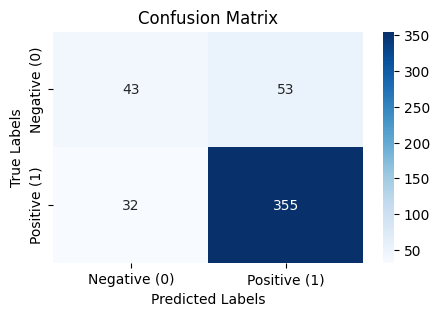

In [16]:
# Initializing the performance evaluator class for vader
vader_performance_evaluator = ClassificationEvaluator(true_labels=vader_test_df['sentiment'], 
                                                      predicted_labels=vader_test_df['vader_sentiment_label'])

vader_performance_evaluator.evaluate()
vader_performance_evaluator.plot_confusion_matrix()

# 3. RNN 

### 3.1. Getting the dataset ready for training the embeddings

In [17]:
rnn_train_df = train_datapreprocessor.preprocess(remove_spam=True, remove_hashtags=True, remove_link=True, remove_whitespace_html=True, clean_text=True, balance_classes=False)
rnn_test_df = test_datapreprocessor.preprocess(remove_spam=True, remove_hashtags=True, remove_link=True, remove_whitespace_html=True, clean_text=True, balance_classes=False)

c:\Users\Diya\Documents\GItHub\DELTA_Element3\DataPreprocess.py:114: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\Diya\Documents\GItHub\DELTA_Element3\DataPreprocess.py:114: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
i = 83
rnn_train_df['content'][i], rnn_train_df['cleaned_content'][i], rnn_train_df['sentiment'][i]

('#Bitcoin worth 4 billion dollars is going to expire tomorrow.\n\nPUMP OR DUMP? 🤔\n\nComment below👇 https://t.co/1qSSdjqxbm',
 'bitcoin worth 4 billion dollar is going to expire tomorrow pump or dump comment below',
 0)

### 3.2. Training the FastText embeddings

In [23]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Diya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Diya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [133]:
# Tokenize the cleaned tweets (split by spaces)
tokenized_tweets = [tweet.split() for tweet in rnn_train_df['cleaned_content']]

# Train FastText model using Gensim's implementation
fasttext_model = FastText(sentences=tokenized_tweets, vector_size=50, window=5, min_count=1, sg=0, epochs=10)

# Save the model
#fasttext_model.save("fasttext_vs50.model")

# Load the model (for future use)
#fasttext_model = FastText.load("fasttext_vs50.model")

In [134]:
# Example: Get vector for a word 
print(f"Vector for 'bitcoin': {fasttext_model.wv['bitcoin']}")

# Example: Get most similar words
print(f"Words similar to 'bitcoin': {fasttext_model.wv.most_similar('bitcoin')}")

Vector for 'bitcoin': [-0.6709714  -0.05345258  0.7476298  -0.2543349  -0.62886745  0.40400296
 -1.1320063   1.3510029  -0.33217534  0.44835895  0.9751155  -0.30870324
  0.38647443 -0.7163215  -0.41597685  1.5855818   0.9373837  -1.2110385
 -1.0085361  -1.1218596  -0.30663407  0.83347434  0.29328728  1.1098998
  0.15832582  0.6114857  -1.0698082  -0.14885026 -1.180415    0.4138586
  2.0033493   0.50779194 -0.4973854   1.8950663  -0.3076839   0.7136994
 -0.21468124  0.4363704  -0.09990931 -0.17263822  0.3457449   1.1145879
 -0.41422155  1.3765805   0.7762243  -1.7805077   1.064602   -0.18881738
 -0.08303882  0.94536465]
Words similar to 'bitcoin': [('bitcoinfrogs', 0.9999940991401672), ('swanbitcoin', 0.9999939799308777), ('bitcoinbaytpa', 0.9999924898147583), ('bitcoinjunglecr', 0.9999906420707703), ('bitcoinpunks', 0.9999905228614807), ('bitcoinlivedb', 0.9999896883964539), ('bitcoincows', 0.9999894499778748), ('bitcoinapes', 0.9999852776527405), ('bitcoinwith', 0.9999850988388062), (

### 3.3. Building and Training the RNN model

 Create a plot to decide on sequence length|

In [135]:
# Parameters
max_sequence_length = 40
embedding_dim = 50
embedding_matrix = fasttext_model.wv.vectors # Create embedding matrix
vocab_size = len(fasttext_model.wv)

In [136]:
#fasttext_model.wv.vector_size, len(tokenizer.word_counts), vocab_size, tokenizer.word_index.items()

In [137]:
# Tokenize the tweets
tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(rnn_train_df['cleaned_content'])

# sequences are tweets transformed into arrays where each word is sequentially replaced by a number which corresponds to the index of that word in the vocabulary
train_sequences = tokenizer.texts_to_sequences(rnn_train_df['cleaned_content']) 
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')

test_sequences = tokenizer.texts_to_sequences(rnn_test_df['cleaned_content'])
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

In [138]:
padded_test_sequences

array([[  13,   13,    5, ...,    0,    0,    0],
       [   2,  205,    9, ...,   16,    8, 4739],
       [ 122,  370,  464, ...,    0,    0,    0],
       ...,
       [   1,    1, 2925, ...,    0,    0,    0],
       [ 351,  534,  677, ...,    0,    0,    0],
       [  24,   23,  121, ...,    5,   94,   56]])

In [139]:
# Dimension check
padded_train_sequences.shape, rnn_train_df['sentiment'].shape

((1438, 40), (1438,))

In [140]:
# Split the data to training and validation
X_train, X_val, y_train, y_val = train_test_split(padded_train_sequences, rnn_train_df['sentiment'], test_size = 0.2, random_state = 9)
# Changing the dtype from series to array
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

# Preparing the test data
rnn_X_test = padded_test_sequences
rnn_y_test = rnn_test_df['sentiment'].to_numpy()

In [141]:
# Calculate the class weights to handle imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.625570776255708, 1: 0.6176154672395274}

Study about kernel_regularizer, learning_rate

In [150]:
from tensorflow.keras.metrics import AUC, Precision, Recall

# Build the RNN model
def build_rnn_model(embd_dim, rnn_type='LSTM'):
    model = Sequential()
    model.add(Input(shape=(max_sequence_length,)))
    model.add(Embedding(input_dim = vocab_size, 
                        output_dim = embd_dim, 
                        weights=[embedding_matrix],  
                        trainable=False))
    
    if rnn_type == 'LSTM':
        model.add(LSTM(units = 64, return_sequences = False, kernel_regularizer=l2(0.02)))
    elif rnn_type == 'GRU':
        model.add(GRU(units = 64, return_sequences= False, kernel_regularizer=l2(0.02)))
        
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.02)))
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy']) #, Precision(), Recall(), AUC()])
    return model

In [151]:
# Initialize the model
model = build_rnn_model(embd_dim=embedding_dim, rnn_type='LSTM')
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 40, 50)         │       292,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,805 (1.23 MB)

 Trainable params: 29,505 (115.25 KB)

 Non-trainable params: 292,300 (1.12 MB)

In [156]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=16, validation_data=(X_val, y_val), class_weight=class_weights, callbacks=[early_stopping])

Epoch 1/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4939 - loss: 1.0730 - val_accuracy: 0.7326 - val_loss: 1.0258
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6238 - loss: 1.0150 - val_accuracy: 0.2014 - val_loss: 1.0464
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5249 - loss: 1.0137 - val_accuracy: 0.7292 - val_loss: 0.9695
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6550 - loss: 0.9764 - val_accuracy: 0.6667 - val_loss: 0.9824
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6564 - loss: 0.9400 - val_accuracy: 0.2014 - val_loss: 0.9913
Epoch 6/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5032 - loss: 0.9414 - val_accuracy: 0.2014 - val_loss: 0.9700
Epoch 7/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4105 - loss: 0.9553 - val_accuracy: 0.7326 - val_loss: 0.9031
Epoch 8/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6922 - loss: 0.8882 - val_accuracy: 0.2014 - v

In [157]:
# Evaluate the model
loss, accuracy = model.evaluate(rnn_X_test, rnn_y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7869 - loss: 0.7775


In [170]:
# Predicting sentiments on new tweets
rnn_predictions = model.predict(rnn_X_test)
# Convert probabilities to binary predictions
rnn_predictions_discrete = (rnn_predictions >= 0.5).astype(int)  

In [147]:
# u = 24
# rnn_predictions[u], rnn_predictions_discrete[u], rnn_y_test[u], rnn_test_df['cleaned_content'].iloc[u]

In [162]:
#rnn_predictions

Classification report:

              precision    recall  f1-score   support

           0       0.43      0.30      0.36        96
           1       0.84      0.90      0.87       387

    accuracy                           0.78       483
   macro avg       0.64      0.60      0.61       483
weighted avg       0.76      0.78      0.77       483



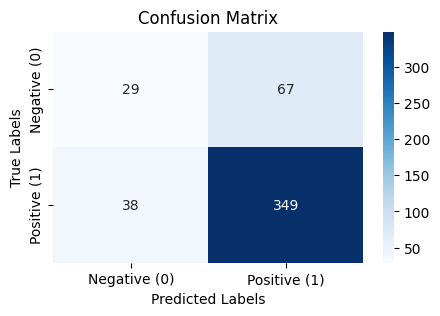

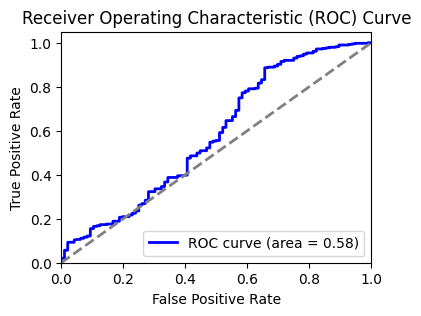

AUC: 0.58


In [171]:
# Initializing the performance evaluator class for RNN
rnn_performance_evaluator = ClassificationEvaluator(true_labels=rnn_y_test, 
                                                    predicted_labels=rnn_predictions_discrete, 
                                                    predicted_probs=rnn_predictions)

rnn_performance_evaluator.evaluate()
rnn_performance_evaluator.plot_confusion_matrix()
rnn_performance_evaluator.plot_roc_auc()

# 4. Pre-trained DistilBERT

### Fine tuning DistilBERT

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, TextClassificationPipeline

In [ ]:
from transformers import pipeline

In [ ]:
classifier = pipeline('sentiment-analysis',
                      model = 'distilbert-base-uncased-finetuned-sst-2-english',
                      tokenizer='distilbert-base-uncased',
                      batch_size=16)

In [ ]:
classifier('Bitcoin in 2 months. Be ready for upcoming rocket ralley.')

In [ ]:
def pipeline_classify(data):
    ''' Function to run the sentiment analysis pipeline on each row of a dataset
    and extract the scores. '''

    predictions = []

    for row in data:
          classification = classifier(row, truncation=True)[0]
          if classification['label'] == 'POSITIVE':
              predictions.append(classification['score'])
          else:
              predictions.append(1-classification['score'])
              
    return predictions

In [ ]:
bert_test_df = test_datapreprocessor.preprocess(remove_spam=True, remove_hashtags=True, remove_link=True, remove_whitespace_html=True, remove_emoji=False)

In [ ]:
bert_test_df.head()

In [ ]:
bert_pred = pipeline_classify(bert_test_df['cleaned_content'])

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

def assess_sentiment_classifier(ytest, yhat, cutoff=0.5, plot_roc=True):
    ''' Function to assess a classification model in terms of the AUC
    and classification accuracy. '''

    # Calculate discrete class predictions
    yhat_discrete = np.where(pd.DataFrame(yhat)>cutoff, 1, 0)
    # Calculate classification accuracy and AUC
    acc = accuracy_score(ytest, yhat_discrete)
    auc = roc_auc_score(ytest, yhat)
    # Confusion matrix 
    cmat = confusion_matrix(ytest, yhat_discrete)
    # ROC analysis
    if plot_roc==True:
        fpr, tpr, _ = roc_curve(ytest, yhat)
        plt.plot(fpr,tpr, label="AUC={:.4}".format(auc));
        plt.plot([0, 1], [0, 1], "r--")
        plt.ylabel('True positive rate')    
        plt.xlabel('False positive rate')    
        plt.legend(loc='lower right')
        plt.show();
    
    print("NN test set performance:\tAUC={:.4f}\tAccuracy={:.4f}".format(auc, acc))
    print('Confusion matrix:')
    print(cmat)

In [ ]:
assess_sentiment_classifier(test_labels, bert_pred)

In [ ]:
bert_pred

In [ ]:
bert_train_df = train_datapreprocessor.preprocess(remove_spam=False, remove_hashtags=True, remove_link=True, remove_whitespace_html=True)
bert_test_df = test_datapreprocessor.preprocess(remove_spam=False, remove_hashtags=True, remove_link=True, remove_whitespace_html=True)

In [ ]:
bert_train_df.head()

In [ ]:
# Dataset Preparation for Handling Tweet Data
class TweetDataset:
    def __init__(self, texts, labels=None, tokenizer=None, max_len=40):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    # Tokenize the text samples and prepares them for input into the model.
    def encode(self):
        encodings = self.tokenizer(
            self.texts,
            truncation=True,
            padding=True,
            max_length=self.max_len,
            return_tensors='tf'
        )
        return encodings
    
    # Converts the tokenized texts and labels into a TensorFlow Dataset object.
    def prepare_data(self):
        encodings = self.encode()
        if self.labels is not None:
            dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), self.labels))
        else:
            dataset = tf.data.Dataset.from_tensor_slices(dict(encodings))
        return dataset

In [ ]:
# Class to Fit Pretrained DistilBERT and Fine-Tune It
class SentimentAnalyzer:
    def __init__(self, model_name='distilbert-base-uncased', num_labels=2):
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        self.model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    def fit_pretrained(self, test_texts, batch_size=16):
        test_dataset = TweetDataset(texts=test_texts, tokenizer=self.tokenizer).prepare_data()
        test_dataset = test_dataset.batch(batch_size)

        predictions = self.model.predict(test_dataset).logits
        predictions = tf.argmax(predictions, axis=-1).numpy()

        return predictions

    def fine_tune(self, train_texts, train_labels, test_texts, test_labels, batch_size=16, epochs=3):
        train_dataset = TweetDataset(texts=train_texts, labels=train_labels, tokenizer=self.tokenizer).prepare_data()
        test_dataset = TweetDataset(texts=test_texts, labels=test_labels, tokenizer=self.tokenizer).prepare_data()

        train_dataset = train_dataset.shuffle(len(train_texts)).batch(batch_size)
        test_dataset = test_dataset.batch(batch_size)
        
        # Assuming train_labels is your array of labels
        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
        class_weight_dict = dict(enumerate(class_weights))

        #optimizer = Adam(learning_rate=5e-5)
        self.model.compile(optimizer='adam', 
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #self.model.compute_loss, 
                           metrics=['accuracy'])

        history = self.model.fit(
            train_dataset,
            validation_data=test_dataset,
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weight_dict
        )

        return history

In [ ]:
#train_texts = bert_train_df['cleaned_content'].tolist()
#train_labels = bert_train_df['sentiment'].tolist()
test_texts = bert_test_df['cleaned_content'].tolist()
test_labels = bert_test_df['sentiment'].tolist()

In [ ]:
train_texts

In [ ]:
# Initialize the SentimentAnalyzer
sentiment_analyzer = SentimentAnalyzer()

### Pretrained predictions


In [ ]:
# Fit Pretrained DistilBERT on Test Dataset
pretrained_predictions = sentiment_analyzer.fit_pretrained(test_texts=test_texts)

In [ ]:
# Class to Evaluate the Model's Performance
class PerformanceEvaluator:
    def __init__(self):
        pass

    def evaluate(self, true_labels, predicted_labels):
        print('Classification report:\n')
        return print(classification_report(true_labels, predicted_labels))

    def plot_confusion_matrix(self, true_labels, predicted_labels):
        cm = confusion_matrix(true_labels, predicted_labels)
        plt.figure(figsize=(6, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative (0)', 'Positive(1)'], yticklabels=['Negative (0)', 'Positive(1)'])
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

In [ ]:
# Initialize PerformanceEvaluator
evaluator = PerformanceEvaluator(true_labels=test_labels, predicted_labels=pretrained_predictions)
evaluator.evaluate()
evaluator.plot_confusion_matrix()

In [ ]:
np.unique(test_labels, return_counts=True)

In [ ]:
np.unique(pretrained_predictions, return_counts=True)

### Fine tuned predictions

In [ ]:
# Fine tune on train dataset and apply on test dataset
sentiment_analyzer.fine_tune(train_texts, train_labels, test_texts, test_labels)

In [ ]:
fine_tuned_predictions = sentiment_analyzer.fit_pretrained(test_texts)

In [ ]:
fine_tuned_predictions

In [ ]:
evaluator.evaluate(true_labels=test_labels, predicted_labels=fine_tuned_predictions)
evaluator.plot_confusion_matrix(true_labels=test_labels, predicted_labels=fine_tuned_predictions)

In [ ]:
print(tf.__version__)

In [ ]:
import transformers
print(transformers.__version__)

In [ ]:
classifier = pipeline('sentiment-analysis')

In [ ]:
res = classifier(cleaned_train_df['content'][3])

In [ ]:
print(res)

In [ ]:
cleaned_train_df['content'][3]

In [ ]:
cleaned_train_df['sentiment'][3]

In [ ]:
cleaned_test_df['sentiment'].value_counts()

In [ ]:
len(X_train[0])

In [ ]:
invalid_roe = [index for index, row in enumerate(X_val) if len(row) > 50]

print(invalid_roe)

In [ ]:
# Tokenize the text
tokenizer = Tokenizer(num_words=5000, oov_token=1)
# The oov_token is a placeholder token that replaces any OOV words during the text_to_sequence calls.
#This ensures that your model can handle new, unseen words gracefully.
tokenizer.fit_on_texts(X_train)

In [ ]:
# On how many tweets did we train?
print(tokenizer.document_count)

In [ ]:
# How many unique words?
len(tokenizer.word_counts)

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [ ]:
# Pad the sequences
max_length = 28  # Set max length for padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

In [ ]:
import numpy as np

# Create an embedding matrix
embedding_dim = 100  # Must match the dimension of FastText vectors
vocab_size = len(tokenizer.word_index) + 1   #it's the total number of unique words in your tokenizer’s vocabulary plus one. The +1 accounts for the padding token (index 0).
embedding_matrix = np.zeros((vocab_size, embedding_dim)) #embedding_matrix is initialized as a matrix of zeros with shape (vocab_size, embedding_dim). 
                                                        #This matrix will eventually hold the FastText vectors for each word in your vocabulary.

for word, i in tokenizer.word_index.items():
    if word in fasttext_model.wv:
        embedding_matrix[i] = fasttext_model.wv[word]

print(f"Embedding matrix shape: {embedding_matrix.shape}")

In [ ]:
embedding_matrix

### RNN Model

In [ ]:
#import keras as kp

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_length, 
                    trainable=False))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
import gensim
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# Assuming 'contents' is the column with the tweets and 'sentiment' is the label (0 or 1)
texts = cleaned_train_df['cleaned_contents'].astype(str).tolist() 
labels = cleaned_train_df['sentiment'].values

# Load pre-trained FastText embeddings
fasttext.util.download_model('en', if_exists='ignore')  # Download the model if not already present
ft = fasttext.load_model('cc.en.300.bin')  # Load the pre-trained FastText model

# Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences to ensure uniform input length
max_sequence_length = 50  # You can adjust this based on your data
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Create an embedding matrix using the FastText embeddings
embedding_dim = 300  # FastText embeddings typically have 300 dimensions
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = ft.get_word_vector(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Build the RNN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_sequence_length, 
                    trainable=False))  # Set trainable to False to keep FastText embeddings static
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, 
          epochs=10, 
          batch_size=32, 
          validation_data=(X_val, y_val), 
          class_weight=class_weights_dict)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

